In [6]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\dmitr\appdata\local\temp\pip-req-build-zszhw6t0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\dmitr\AppData\Local\Temp\pip-req-build-zszhw6t0'


In [1]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import cv2
import pillow_heif
import os
import logging
import torch
import io
plt.rcParams['figure.figsize'] = [15, 10]

#### Function to activate SAM model

#### Download the SAM pretrained model files

* vit_h - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
* vit_b - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [2]:
def activate_model(model_name = 'vit_h'):

    # Define SAM model directory and model names
    SAM_dir = 'SAM_checkpoint'
    model_vit_h_name = 'sam_vit_h_4b8939.pth'
    model_vit_b_name = 'sam_vit_b_01ec64.pth'
    
    # Create directory to store SAM pretrained models
    os.makedirs(SAM_dir, exist_ok=True)

    # Check if model file is in the folder
    model_vit_h_path = os.path.join(SAM_dir, model_vit_h_name)
    model_vit_b_path = os.path.join(SAM_dir, model_vit_b_name)

    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model_name == 'vit_h':
        if os.path.exists(model_vit_h_path):
            sam = sam_model_registry["vit_h"](checkpoint="SAM_checkpoint/sam_vit_h_4b8939.pth")
        else:
            print('Model file has not been identified - please upload it here https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth')
    
    elif model_name == 'vit_b':
        if os.path.exists(model_vit_b_path):
            sam = sam_model_registry["vit_b"](checkpoint="SAM_checkpoint/sam_vit_b_01ec64.pth")
        else:
            print('Model file has not been identified - please upload it here https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth')
    
    else:
        raise ValueError("Invalid model name")
    
    # Move model to the selected device (GPU if available, otherwise CPU)
    sam.to(device)
    
    return sam, device

In [3]:
# Activate Automatic Mask Generator and Predictor
sam, device = activate_model()
mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

C:\Users\dmitr\anaconda3\envs\pytorch_311\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## STEP 1: Convert images from HEIC to JPEG format and store them in the separate folder

##### link to the github - https://github.com/dragonGR/PyHEIC2JPG/blob/master/main.py

In [4]:
%%time

# Dictionary to store JPEG images
jpeg_imgs_dict = {}

logging.basicConfig(level=logging.INFO, format='%(message)s')

# List all the HEIC files
heic_dir = '1_rcpt_img_heic'
heic_imgs = [file for file in os.listdir(heic_dir) if file.lower().endswith('.heic')]
total_imgs = len(heic_imgs)

# Convert each HEIC file to JPEG
num_converted = 0
for heic_img_index, heic_img_name in enumerate(heic_imgs, start=1):
    
    img_name = os.path.splitext(heic_img_name)[0]
    heic_path = os.path.join(heic_dir, heic_img_name)

    try:
        # Open the HEIC file using pyheif
        with open(heic_path, 'rb') as heic_file:
            heif_file = pillow_heif.open_heif(heic_file)
            pil_img = Image.frombytes(
                heif_file.mode,
                heif_file.size,
                heif_file.data,
                'raw',
                heif_file.mode,
                heif_file.stride
            )
        
        # Convert the PIL image to JPEG in memory
        with io.BytesIO() as output:
            pil_img.save(output, format='JPEG')
            jpeg_data = output.getvalue()

        # Load the JPEG data into OpenCV format
        jpeg_img = cv2.imdecode(np.frombuffer(jpeg_data, np.uint8), cv2.IMREAD_COLOR)
        jpeg_img = cv2.cvtColor(jpeg_img, cv2.COLOR_BGR2RGB)
        
        # Define JPEG img shape
        height_jpeg_img = jpeg_img.shape[0]
        width_jpeg_img = jpeg_img.shape[1]
        
        # Check orientation of the JPEG image
        if width_jpeg_img / height_jpeg_img > 1:
            jpeg_img = cv2.rotate(jpeg_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        jpeg_imgs_dict[img_name] = jpeg_img
        num_converted += 1
        
        # Calculate and display the percentage progress
        conversion_progress = int((num_converted / total_imgs) * 100)
        print(f'Conversion progress: {conversion_progress}%',  end="\r", flush=True)
    
    except Exception as e:
        logging.error(f'Error converting {heic_img_name}: {str(e)}')

print(f'\nConversion completed successfully. {num_converted} files processed.')

Conversion progress: 100%
Conversion completed successfully. 16 files processed.
CPU times: total: 4.53 s
Wall time: 6.3 s


## STEP 2: Resize JPEG images to 320 pixel height

#### Define resize function

In [5]:
def resize_image(img, height = 320):

    # Define img shape
    height_img = img.shape[0]
    width_img = img.shape[1]

    # Define resizing ratio
    ratio = round(height / height_img, 3)

    # Resize input image if height is more than 320 pixels
    if height_img > height:
        width = int(width_img * ratio)
        new_dimensions = (width, height)
        resized_img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_LINEAR)

    # Define resized img shape
    height_resized_img = resized_img.shape[0]
    width_resized_img = resized_img.shape[1]
    
    # Define inverse coefs
    inverse_height = height_img / height_resized_img
    inverse_width = width_img / width_resized_img
    inverse_coefs = (inverse_height, inverse_width)
    
    return resized_img, inverse_coefs

#### Execute resize script 

In [6]:
%%time

# Initiate dict to store resized JPEG images
resized_imgs_dict = {}

num_resized = 0
for img_name, jpeg_img in jpeg_imgs_dict.items():
    
    try:        
        # Resize JPEG image
        resized_img, inverse_coefs = resize_image(jpeg_img) # custom function
        # resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        resized_imgs_dict[img_name] = resized_img
        num_resized += 1
    
        # Calculate and display the percentage progress
        resizing_progress = int((num_resized / total_imgs) * 100)
        print(f'Resizing progress: {resizing_progress}%', end="\r", flush=True)
    
    except Exception as e:
        logging.error(f'Error resizing {img_name}: {str(e)}')

print(f'\nResizing completed successfully. {num_resized} files processed')

Resizing progress: 100%
Resizing completed successfully. 16 files processed
CPU times: total: 15.6 ms
Wall time: 13.5 ms


## STEP 3: Define ROI on the image and obtain input point for further use in SAM model

#### Define function to get input point

In [7]:
def obtain_input_point(img, quad_size=10):

    # Use copy of the input img
    img = np.copy(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Define img shape
    width=img.shape[1]
    height=img.shape[0]

    # Calculate img center
    width_cntr = width // 2
    height_cntr = height // 2
    img_cntr = np.array([[width_cntr, height_cntr]])
    cv2.circle(img, img_cntr[0], radius=0, color=(255,0,0), thickness=2)
    
    # Define a block slice located in the center of the image to check the intensity level
    start_row = height_cntr - quad_size
    end_row = height_cntr + quad_size + 1
    start_col = width_cntr - quad_size
    end_col = width_cntr + quad_size + 1
    
    # Draw a rectangle around the ROI 
    bbox = [[start_col, start_row], [end_col, start_row], [end_col, end_row], [start_col, end_row]]
    bbox_array = np.array(bbox, np.int32)
    bbox_array_reshaped = bbox_array.reshape((-1, 1, 2))
    cv2.polylines(img, [bbox_array_reshaped], isClosed = True, color = (255,0,0), thickness = 1)

    # Check if block located within img
    if start_row < 0 or end_row > height:
        decrease_quad_height = end_row - height
        print(f'Your input point is outside the image, please deacrease the quad_size at least to {quad_size - decrease_quad_height}')
        # Make img center a default input point
        input_point = np.array([[width_cntr, height_cntr]])
    elif start_col < 0 or end_col > width:
        decrease_quad_width = end_col - width
        print(f'Your input point is outside the image, please deacrease the quad_size at least to {quad_size - decrease_quad_width}')
        # Make img center a default input point
        input_point = np.array([[width_cntr, height_cntr]])
    else:
        block_slice = img[start_row:end_row, start_col:end_col,...]
        
        # Define block shape parameters
        block_width = block_slice.shape[1]
        block_height = block_slice.shape[0]
        
        # Define quads within block
        top_left_quad = block_slice[0:quad_size, 0:quad_size,...]
        top_right_quad = block_slice[0:quad_size, quad_size:,...]
        bottom_right_quad = block_slice[quad_size:, quad_size:,...]
        bottom_left_quad = block_slice[quad_size:, 0:quad_size,...]

        # Check intensity surrounding of the picked input
        # Define color intensity within quads
        top_left_intensity = int(np.mean(top_left_quad))
        top_right_intensity = int(np.mean(top_right_quad))
        bottom_right_intensity = int(np.mean(bottom_right_quad))
        bottom_left_intensity = int(np.mean(bottom_left_quad))
        
        # Define quad with maximum intensity
        max_intensity = max(top_left_intensity, top_right_intensity, bottom_left_intensity, bottom_right_intensity)
    
        if max_intensity == top_left_intensity:
            input_point = np.array([[start_col, start_row]])
            # Draw input point
            cv2.circle(block_slice, input_point[0], radius=0, color=(0,255,0), thickness=2)
        
        elif max_intensity == top_right_intensity:
            input_point = np.array([[end_col, start_row]])
            # Draw input point
            cv2.circle(block_slice, input_point[0], radius=0, color=(0,255,0), thickness=2)

        elif max_intensity == bottom_right_intensity:
            input_point = np.array([[end_col, end_row]])
            # Draw input pointt
            cv2.circle(block_slice, input_point[0], radius=0, color=(0,255,0), thickness=2)
        
        elif max_intensity == bottom_left_intensity:
            input_point = np.array([[start_col, end_row]])
            # Draw input point
            cv2.circle(block_slice, input_point[0], radius=0, color=(0,255,0), thickness=2)
    
    return input_point, img

#### Execute input point identification script 

In [8]:
%%time

# Dictionary to store resized JPEG images with ROI in which input point for SAM model defined
resized_imgs_w_roi_dict = {}
input_point_dict = {}

num_roi = 0
for img_name, resized_img in resized_imgs_dict.items():
    
    try:
        input_point, resized_img_w_roi = obtain_input_point(resized_img) # custom function
        input_point_dict[img_name] = input_point
        resized_imgs_w_roi_dict[img_name] = resized_img_w_roi
        num_roi += 1
        
        # Calculate and display the percentage progress
        roi_progress = int((num_roi / total_imgs) * 100)
        print(f'Define ROI progress: {roi_progress}%', end='\r', flush=True)
        
    except Exception as e:
        logging.error(f'Error with ROI identification {img_name}: {str(e)}')

print(f'\nROI identified successfully. {num_roi} files processed')

Define ROI progress: 100%
ROI identified successfully. 16 files processed
CPU times: total: 0 ns
Wall time: 9.84 ms


## STEP 4: Run SAM model on the resized images to obtain receipt mask and store it in the separate folder

#### Define function to segment the image

In [9]:
def mask_image(img, input_point=None, input_label=1):
    
    # Calculate default input point
    if input_point is None:
        raise ValueError('Input point has not been provided')
    
    # Transform input label into array
    input_label = np.array([input_label])
    
    # Embed image
    predictor.set_image(img)
    
    # Segment image
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )
    # Define the mask with the highest score
    max_score_idx = np.argmax(scores)
    masked_img = masks[max_score_idx]
    
    # Convert mask image in np.float32 type
    masked_img = masked_img.astype(np.float32)
    
    return masked_img

#### Execute image segmentation script

In [10]:
%%time

# Initiate dict to store receipt mask that was made on the resized image
masked_imgs_dict = {}

num_masked = 0
for img_name, resized_img in resized_imgs_dict.items():
    
    try:
        input_point = input_point_dict[img_name]
        masked_img = mask_image(resized_img, input_point=input_point) # custom function
        masked_imgs_dict[img_name] = masked_img
        num_masked += 1
        
        # Calculate and display the percentage progress
        segmentation_progress = int((num_masked / total_imgs) * 100)
        print(f'Masking progress: {segmentation_progress}%', end='\r', flush=True)
    
    except Exception as e:
        logging.error(f'Error masking {img_name}: {str(e)}')

print(f'\nMasking completed successfully. {num_masked} files processed')

Masking progress: 100%
Masking completed successfully. 16 files processed
CPU times: total: 15 s
Wall time: 15.4 s


#### Execute quality check for identified masks

In [13]:
%%time

# Calculate masked area
masked_area_dict = {}
for img_name, masked_img in masked_imgs_dict.items():
    masked_area = round(np.count_nonzero(masked_img) / np.size(masked_img), 2)
    masked_area_dict[img_name] = masked_area

# Identify outliers
masked_area_list = np.array(list(masked_area_dict.values()))
masked_area_img_name = np.array(list(masked_area_dict.keys()))
mean_metric = np.mean(masked_area_list)
std_metric = np.std(masked_area_list)
z = (masked_area_list - mean_metric) / std_metric
out_cond = z < -2
outliers_idxs = np.where(out_cond)
corrupted_masked_imgs = masked_area_img_name[out_cond]

CPU times: total: 0 ns
Wall time: 2 ms


## STEP 5: Find corners on the masked images and define bounding box to extract receipt

In [14]:
def obtain_corner_points(img, blockSize=3, ksize=5, k=0.04, percentile=70):

    # Input parameters description
    # blockSize - neighbourhood considered for corner detection
    # ksize - aperture parameter of the Sobel derivative used
    # k - Harris detector free parameter in the equation
    # percentile - filters the stronges corner points
    
    # Find corners
    corner_map_img = cv2.cornerHarris(img, blockSize, ksize, k)
    # Filter values that represents corners
    positive_cornerness = corner_map_img[corner_map_img > 0.0]
    # Calculate the threshold to identify the strongest corner values
    percentile_threshold = np.percentile(positive_cornerness, percentile) # 70th percentile by default
    # Identify potential corner coords
    corner_points = np.where(corner_map_img >= percentile_threshold)
    
    return corner_points, corner_map_img

#### Execute find corners script

In [15]:
%%time

# Dictionary to store corner map that has been executed on the masked image
corner_map_imgs_dict = {}
corner_points_dict = {}

num_cornered = 0
for img_name, masked_img in masked_imgs_dict.items():
    
    try:
        percentile = 70
        corner_points, corner_map_img = obtain_corner_points(masked_img, percentile=percentile) # custom function
        corner_points_dict[img_name] = corner_points
        corner_map_imgs_dict[img_name] = corner_map_img
        num_cornered += 1
        
        # Calculate and display the percentage progress
        cornering_progress = int((num_cornered / total_imgs) * 100)
        print(f'Cornering progress: {cornering_progress}%', end='\r', flush=True)
    
    except Exception as e:
        logging.error(f'Error cornering {img_name}: {str(e)}')

print(f'\nCornering completed successfully. {num_cornered} files processed')

Cornering progress: 100%
Cornering completed successfully. 16 files processed
CPU times: total: 0 ns
Wall time: 21.4 ms


## STEP 6: Extract bbox to crop receipt from the original image

In [16]:
def cluster_corner_points(img, corner_points):
    
    # STEP 0 DEFINE IMG SHAPE AND UNPACK CORNER POINTS
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_width_cntr = img_width / 2
    img_height_cntr = img_height / 2
    
    x_points = corner_points[1]
    y_points = corner_points[0]

    x_y_coords = [[x_points, y_points] for x_points, y_points in zip(x_points, y_points)]
    
    ## STEP 1 SPLIT CORNER COORDINATES INTO TOP AND BOTTOM ##
    
    # Identify y coordinates location with respect to height dimension
    top_bottom = []
    
    for y_point in y_points:
        y_loc = round(y_point / img_height, 2)
        top_bottom.append(y_loc)

    # Check if list is not empty prior to calculate distance and center
    if top_bottom:
        # Calculate distance between top and bottom coordinates
        distance_bottom_top = round(max(top_bottom) - min(top_bottom), 2)
        # Calculate the border between top and bottom
        top_bottom_cntr = round((max(top_bottom) + min(top_bottom)) / 2, 2)
    else:
        # Calculate distance between top and bottom coordinates
        distance_bottom_top = 0.00
        # Use img height center to split between left and right
        top_bottom_cntr = round(img_height_cntr / img_height, 2)

    # Split x, y coordinates to the top and bottom ones
    top_coords = []
    bottom_coords = []
    
    for x_y_coord in x_y_coords:
      y = x_y_coord[1]
      y_loc = round(y / img_height, 2)
    
      if y_loc < top_bottom_cntr:
        top_coords.append(x_y_coord)
      else:
        bottom_coords.append(x_y_coord)

    ## STEP 2 SPLIT CORNER COORDINATES INTO LEFT AND RIGHT FOR TOP AND BOTTOM SEPARATELY ##
    
    # Identify x coordinates location with respect to width dimension
    top_right_left = []
    for top_coord in top_coords:
      x = top_coord[0]
      x_loc = round(x / img_width, 2)
      top_right_left.append(x_loc)
    
    bottom_right_left = []
    for bottom_coord in bottom_coords:
      x = bottom_coord[0]
      x_loc = round(x / img_width, 2)
      bottom_right_left.append(x_loc)

    # Check if top points has been identified
    if top_right_left:
        # Calculate distance between right and left for top coordinates
        distance_top_r_l = round(max(top_right_left) - min(top_right_left), 2)
    else:
        # Use img width center to split between left and right
        distance_top_r_l = 0.00
    
    # Check if bottom points has been identified
    if bottom_right_left:
        # Calculate distance between right and left for bottom coordinates
        distance_bottom_r_l = round(max(bottom_right_left) - min(bottom_right_left), 2)
    else:
        # Use img width center to split between left and right
        distance_bottom_r_l = 0.00

    # Calculate the border between left and right for top and bottom separately
    if distance_top_r_l >= 0.05 and distance_bottom_r_l >= 0.05:
        status = 0
        top_right_left_cntr = round((max(top_right_left) + min(top_right_left)) / 2, 2)
        bottom_right_left_cntr = round((max(bottom_right_left) + min(bottom_right_left)) / 2, 2)
    
    elif distance_top_r_l >= 0.05 and distance_bottom_r_l <= 0.05:
        status = 1
        top_right_left_cntr = round((max(top_right_left) + min(top_right_left)) / 2, 2)
        bottom_right_left_cntr = round((max(top_right_left) + min(top_right_left)) / 2, 2)
    
    elif distance_top_r_l <= 0.05 and distance_bottom_r_l >= 0.05:
        status = 1
        top_right_left_cntr = round((max(bottom_right_left) + min(bottom_right_left)) / 2, 2)
        bottom_right_left_cntr = round((max(bottom_right_left) + min(bottom_right_left)) / 2, 2)
        
    else:
        status = 2
        top_right_left_cntr = round(img_width_cntr / img_width, 2)
        bottom_right_left_cntr = round(img_width_cntr / img_width, 2)

    # Split corner coordinates into top left, top right, bottom right, bottom left
    top_left_points = []
    top_right_points = []
    bottom_right_points = []
    bottom_left_points = []
    
    for top_coord in top_coords:
        x = top_coord[0]
        x_loc = round(x / img_width, 2)

        if x_loc < top_right_left_cntr:
            top_left_points.append(top_coord)
        else:
            top_right_points.append(top_coord)
    
    for bottom_coord in bottom_coords:
        x = bottom_coord[0]
        x_loc = round(x / img_width, 2)
        
        if x_loc < bottom_right_left_cntr:
            bottom_left_points.append(bottom_coord)
        else:
            bottom_right_points.append(bottom_coord)

    # Calculate receipt aspect ratio to identify cases where width bigger than height, that is not usual for receipt shape 
    ratio_1 = distance_top_r_l/distance_bottom_top
    ratio_2 = distance_bottom_r_l/distance_bottom_top

    if ratio_1 > 1 or ratio_2 > 1:
        status = 3
    
    clustered_points = [top_left_points, top_right_points, bottom_right_points, bottom_left_points]
   
    return clustered_points, status

In [17]:
def extract_bbox_coords(clustered_points):

    # Check how many clustered points is missing, if more then 2 
    count = sum(1 for clustered_point in clustered_points if not clustered_point)
    
    if count < 2:

        # Unpack clustered points
        top_left_points, top_right_points, bottom_right_points, bottom_left_points = clustered_points
        
        if not bottom_right_points:
            # print(f'Bottom right points is missing')
            width = top_right_points[0][0] - top_left_points[0][0]
            bottom_right_points = [[bottom_left_points[0][0] + width, bottom_left_points[0][1]]]
    
        if not bottom_left_points:
            # print(f'Bottom left points is missing')
            width = top_right_points[0][0] - top_left_points[0][0]
            bottom_left_points = [[bottom_right_points[0][0] - width, bottom_right_points[0][1]]]
        
        if not top_right_points:
            # print(f'Top right points is missing')
            width = bottom_right_points[0][0] - bottom_left_points[0][0]
            top_right_points = [[top_left_points[0][0] + width, top_left_points[0][1]]]
        
        if not top_left_points:
            # print(f'Top left points is missing')
            width = bottom_right_points[0][0] - bottom_left_points[0][0]
            top_left_points = [[top_right_points[0][0] - width, top_right_points[0][1]]]
    
        # Define points with maximum distance betweem  top left and bottom right
        coord_dict_0 = {}
    
        for idx_1, top_left_point in enumerate(top_left_points):
            for idx_2, bottom_right_point in enumerate(bottom_right_points):
                
                x_left = top_left_point[0]
                y_left = top_left_point[1]
                x_right = bottom_right_point[0]
                y_right = bottom_right_point[1]
                
                distance = (x_left - x_right) ** 2 + (y_left - y_right) ** 2
                
                coord_dict_0[idx_1, idx_2] = distance
        
        # Define points with maximum distance betweem  top right and bottom left
        coord_dict_1 = {}
    
        for idx_1, top_right_point in enumerate(top_right_points):
            for idx_2, bottom_left_point in enumerate(bottom_left_points):
                
                x_right = top_right_point[0]
                y_right = top_right_point[1]
                x_left = bottom_left_point[0]
                y_left = bottom_left_point[1]
                
                distance = (x_left - x_right) ** 2 + (y_left - y_right) ** 2
                
                coord_dict_1[idx_1, idx_2] = distance
    
        # Get points
        max_key_0 = max(coord_dict_0, key=coord_dict_0.get)
        max_key_1 = max(coord_dict_1, key=coord_dict_1.get)
        
        top_left_point = top_left_points[max_key_0[0]]
        top_right_point = top_right_points[max_key_1[0]]
        bottom_right_point = bottom_right_points[max_key_0[1]]
        bottom_left_point = bottom_left_points[max_key_1[1]]
    
        bbox = np.array([top_left_point, top_right_point, bottom_right_point, bottom_left_point])
    else:
        bbox =  np.array([[0, 0], [0, 0], [0, 0], [0, 0]])

    return bbox

In [18]:
def get_rectangular_bbox(bbox):
    
    # Calculate the convex hull of the points
    hull = cv2.convexHull(bbox)
    # Calculate the rotated bounding box of the convex hull
    rect = cv2.minAreaRect(hull)
    # Extract the center, size, and angle of the bounding box
    center, (width, height), angle = rect
    # Compute the four corners of the bounding box
    box_rect = cv2.boxPoints(rect)
    box_rect = np.asarray(box_rect, dtype=int)
    # Ensure the box points are in the correct order
    box_rect = box_rect[np.argsort(np.arctan2(box_rect[:,1] - center[1], box_rect[:,0] - center[0]))]
    
    return box_rect, angle

In [19]:
def get_coord_for_orgnl_size(bbox_rszd, inverse_coef_width, inverse_coef_height, expand_by = 60):
    
    top_left_rszd, top_right_rszd, bottom_right_rszd, bottom_left_rszd = bbox_rszd
    top_left_orgnl = [int(top_left_rszd[0] * inverse_coef_width)-expand_by, int(top_left_rszd[1] * inverse_coef_height)-expand_by]
    top_right_orgnl = [int(top_right_rszd[0] * inverse_coef_width)+expand_by, int(top_right_rszd[1] * inverse_coef_height)-expand_by]
    bottom_right_orgnl = [int(bottom_right_rszd[0] * inverse_coef_width)+expand_by, int(bottom_right_rszd[1] * inverse_coef_height)+expand_by]
    bottom_left_orgnl = [int(bottom_left_rszd[0] * inverse_coef_width)-expand_by, int(bottom_left_rszd[1] * inverse_coef_height)+expand_by]
    bbox = [top_left_orgnl, top_right_orgnl, bottom_right_orgnl, bottom_left_orgnl]
    
    return bbox

In [20]:
def draw_bbox(img, bbox):
    
    img_w_bbox = np.copy(img)
    # img_w_bbox = cv2.cvtColor(img_w_bbox, cv2.COLOR_BGR2RGB)
    bbox_array = np.array(bbox, np.int32)
    bbox_array_reshaped = bbox_array.reshape((-1, 1, 2))
    img_w_bbox = cv2.polylines(img_w_bbox, [bbox_array_reshaped], isClosed = True, color = (255,0,0), thickness = 5)
    
    return img_w_bbox

In [21]:
%%time

# Dictionary to store original image with the bbox around the receipt
imgs_with_bbox_dict = {}
bbox_for_warp_dict = {}

# Calculate coordinate inverse coef
inverse_coef_height, inverse_coef_width = inverse_coefs

all_corners_identified = []
one_corner_missed = []
two_corner_missed = []

corrupted_aspect_ratio = []

num_bboxed = 0
for img_name, resized_img in resized_imgs_dict.items():
    try:
        corner_points = corner_points_dict[img_name]
        # Cluster corner points into top left, top right, bottom right and bottom left
        clustered_points, status = cluster_corner_points(resized_img, corner_points)
        
        if status == 0:
            all_corners_identified.append(img_name)
        elif status == 1:
            one_corner_missed.append(img_name)
        elif status == 2:
            two_corner_missed.append(img_name)
        elif status == 3:
            if img_name not in corrupted_masked_imgs:
                corrupted_aspect_ratio.append(img_name)

        # Extract initial bbox coords
        bbox_initial = extract_bbox_coords(clustered_points)
        # Align bbox coordinates to match a rectangle
        bbox_rect, angle = get_rectangular_bbox(bbox_initial)
        # Inverse bbox coords to the original JPEG image size
        bbox_final = get_coord_for_orgnl_size(bbox_rect, inverse_coef_width, inverse_coef_height) # custom function
        bbox_for_warp_dict[img_name] = bbox_final
        # Draw bbox on the original image
        orgnl_img = jpeg_imgs_dict[img_name]
        img_with_bbox = draw_bbox(orgnl_img, bbox_final)
        imgs_with_bbox_dict[img_name] = img_with_bbox
        num_bboxed += 1
    
    except Exception as e:
        logging.error(f'Error cornering {img_name}: {str(e)}')

    # Calculate and display the percentage progress
    draw_progress = int((num_bboxed / total_imgs) * 100)
    print(f'Draw bboxes progress: {draw_progress}%', end='\r', flush=True)

print(f'\nDraw bboxes completed successfully. {num_bboxed} files processed')

Draw bboxes progress: 100%
Draw bboxes completed successfully. 16 files processed
CPU times: total: 15.6 ms
Wall time: 91.3 ms


#### Check if any missing corners exist

In [22]:
%%time

# Understand the distribution of identified corners that affects the ability to build bounding box
all_corners_identified_share = round((len(all_corners_identified) / total_imgs) * 100, 2)
one_corner_missed_share = round((len(one_corner_missed) / total_imgs) * 100, 2)
two_corner_missed_share = round((len(two_corner_missed) / total_imgs) * 100, 2)

print(
f'All corners identified: {all_corners_identified_share}%'
f'\nOne corner missed: {one_corner_missed_share}%'
f'\nTwo corner missed: {two_corner_missed_share}%'
)

All corners identified: 68.75%
One corner missed: 25.0%
Two corner missed: 6.25%
CPU times: total: 0 ns
Wall time: 0 ns


## STEP 7: Crop rcpt img based on bbox input

In [23]:
def get_src_dst(bbox):
    
    # Define src points
    src = np.float32(bbox)

    top_left_orgnl, top_right_orgnl, bottom_right_orgnl, bottom_left_orgnl = bbox

    # Define dst points
    width_top_x = top_right_orgnl[0] - top_left_orgnl[0]
    width_top_y = top_right_orgnl[1] - top_left_orgnl[1]
    width_bottom_x = bottom_right_orgnl[0] - bottom_left_orgnl[0]
    width_bottom_y = bottom_right_orgnl[1] - bottom_left_orgnl[1]
    height_left_x = bottom_left_orgnl[0] - top_left_orgnl[0]
    height_left_y = bottom_left_orgnl[1] - top_left_orgnl[1]
    height_right_x = bottom_right_orgnl[0] - top_right_orgnl[0]
    height_right_y = bottom_right_orgnl[1] - top_right_orgnl[1]
    
    width_1 = np.sqrt((width_top_x ** 2) + ((width_top_y) ** 2))
    width_2 = np.sqrt(((width_bottom_x) ** 2) + ((width_bottom_y) ** 2))
    maxWidth = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt((height_left_x ** 2) + ((height_left_y) ** 2))
    height_2 = np.sqrt(((height_right_x) ** 2) + ((height_right_y) ** 2))
    maxHeight = max(int(height_1), int(height_2))
    
    max_W_H = (maxWidth, maxHeight)
    
    dst = np.float32([[0, 0],
                      [maxWidth - 1, 0],
                      [maxWidth - 1, maxHeight - 1],
                      [0, maxHeight - 1]
                     ]
                    )
    return src, dst, max_W_H

In [24]:
def apply_warp_perspective(img, src, dst, frame):
    # Compute the homography matrix (you'll have to use getPerspectiveTransform function from OpenCV here)
    M = cv2.getPerspectiveTransform(src, dst)
    # Build the rectified image using the computed matrix (you'll have to use warpPerspective function from OpenCV)
    warped_img = cv2.warpPerspective(img, M, frame)

    return warped_img

In [25]:
%%time

# Dictionary to store croped receipt image
croped_imgs_dict = {}

num_croped = 0
for img_name, jpeg_img in jpeg_imgs_dict.items():

    # Obtain bbox to apply warp
    bbox_for_warp = bbox_for_warp_dict[img_name]
    # Obtain src and dst point to apply warp perspective
    src, dst, frame = get_src_dst(bbox_for_warp) # custom function
    # Crop image
    croped_img = apply_warp_perspective(jpeg_img, src, dst, frame) # custom function
    # Save croped image
    croped_imgs_dict[img_name] = croped_img
    num_croped += 1
    
    # Calculate and display the percentage progress
    crop_progress = int((num_croped / total_imgs) * 100)
    print(f'Crop progress: {crop_progress}%', end='\r', flush=True)

print(f'\nCrop completed successfully. {num_croped} files processed')

Crop progress: 100%
Crop completed successfully. 16 files processed
CPU times: total: 109 ms
Wall time: 42.4 ms


## STEP 8: Estimate the success rate of the pipeline

In [26]:
%%time

# Calculate the success rate of the pipeline
combined_issue_lists = set(list(corrupted_masked_imgs) + two_corner_missed + corrupted_aspect_ratio)
total_failed = len(combined_issue_lists)
success_rate = round((total_imgs - total_failed) / total_imgs * 100, 2)
print(f'Success rate: {success_rate}%')

Success rate: 93.75%
CPU times: total: 0 ns
Wall time: 0 ns


## STEP 9: Save imgs from dict to the folders

In [27]:
%%time

num_saved = 0
for img_name in jpeg_imgs_dict.keys():
    
    img_name_w_ext = img_name + '.jpeg'
    
    # Define image to save
    jpeg_img = jpeg_imgs_dict[img_name]
    jpeg_img = cv2.cvtColor(jpeg_img, cv2.COLOR_BGR2RGB)
    resized_img = resized_imgs_dict[img_name]
    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img_w_roi = resized_imgs_w_roi_dict[img_name]
    resized_img_w_roi = cv2.cvtColor(resized_img_w_roi, cv2.COLOR_BGR2RGB)
    masked_img = masked_imgs_dict[img_name]
    masked_img = (masked_img * 255).astype(np.uint8)
    corner_map_img = corner_map_imgs_dict[img_name]
    imgs_with_bbox = imgs_with_bbox_dict[img_name]
    imgs_with_bbox = cv2.cvtColor(imgs_with_bbox, cv2.COLOR_BGR2RGB)
    croped_img = croped_imgs_dict[img_name]
    croped_img = cv2.cvtColor(croped_img, cv2.COLOR_BGR2RGB)
    
    # Define directory
    jpeg_dir = '2_rcpt_img_jpeg'
    resized_dir = '3_rcpt_img_resized'
    resized_w_roi_dir = '4_rcpt_img_resized_w_roi'
    masked_dir = '5_rcpt_img_mask'
    jpeg_bbox_dir = '6_rcpt_img_w_bbox'
    croped_dir = '7_rcpt_img_croped'

    # Create a directory 
    os.makedirs(jpeg_dir, exist_ok=True)
    os.makedirs(resized_dir, exist_ok=True)
    os.makedirs(resized_w_roi_dir, exist_ok=True)
    os.makedirs(masked_dir, exist_ok=True)
    os.makedirs(jpeg_bbox_dir, exist_ok=True)
    os.makedirs(croped_dir, exist_ok=True)

    # Define path
    jpeg_path = os.path.join(jpeg_dir, img_name_w_ext)
    resized_path = os.path.join(resized_dir, img_name_w_ext)
    resized_w_roi_path = os.path.join(resized_w_roi_dir, img_name_w_ext)
    masked_path = os.path.join(masked_dir, img_name_w_ext)
    jpeg_bbox_path = os.path.join(jpeg_bbox_dir, img_name_w_ext)
    croped_path = os.path.join(croped_dir, img_name_w_ext)
    
    # Upload images
    cv2.imwrite(jpeg_path, jpeg_img)
    cv2.imwrite(resized_path, resized_img)
    cv2.imwrite(resized_w_roi_path, resized_img_w_roi)
    cv2.imwrite(masked_path, masked_img)
    cv2.imwrite(jpeg_bbox_path, imgs_with_bbox)
    cv2.imwrite(croped_path, croped_img)
    num_saved += 1
    
    # Calculate and display the percentage progress
    save_progress = int((num_saved / total_imgs) * 100)
    print(f'Saving progress: {save_progress}%', end='\r', flush=True)

print(f'\nSaving completed successfully. {num_croped} files saved')

Saving progress: 100%
Saving completed successfully. 16 files saved
CPU times: total: 4.61 s
Wall time: 4.66 s


## STEP 10: Showcase the results on 1 random image

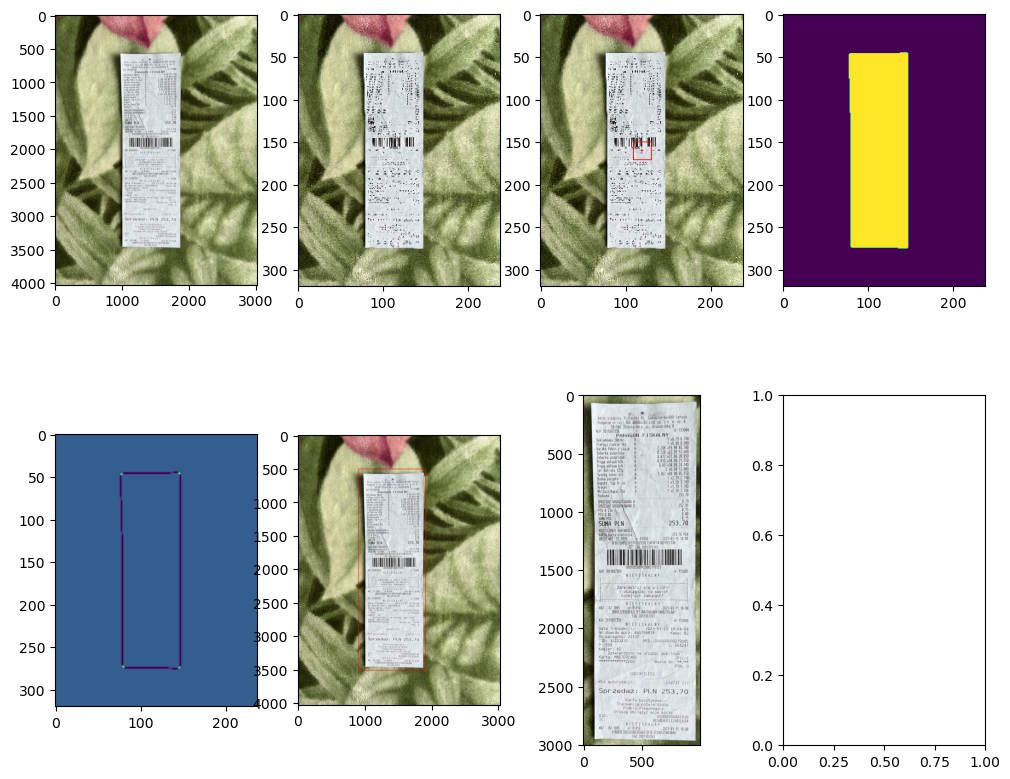

In [28]:
img_names_list = [img_name for img_name in jpeg_imgs_dict.keys()]
random_img_name = random.choice(img_names_list)

# Plot images
nrows, ncols = 2, 4  # array of sub-plots
figsize = [12, 10]   # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

ax[0][0].imshow(jpeg_imgs_dict[random_img_name])
ax[0][1].imshow(resized_imgs_dict[random_img_name])
ax[0][2].imshow(resized_imgs_w_roi_dict[random_img_name])
ax[0][3].imshow(masked_imgs_dict[random_img_name])
ax[1][0].imshow(corner_map_imgs_dict[random_img_name])
ax[1][1].imshow(imgs_with_bbox_dict[random_img_name])
ax[1][2].imshow(croped_imgs_dict[random_img_name])